In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE = 'travistorrent_11_1_2017.csv'

In [3]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_build_started_at',
                                                         'tr_log_num_tests_ok',        
                                                         'tr_log_num_tests_failed' ,   
                                                         'tr_log_num_tests_skipped',
                                                         'gh_sloc'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',
                                                                                            'gh_build_started_at': 'category',
                                                                                            'tr_log_num_tests_ok': np.float32,
                                                                                            'tr_log_num_tests_failed': np.float32,
                                                                                            'tr_log_num_tests_skipped': np.float32,
                                                                                            'gh_sloc': np.int32}, encoding='utf-8')


In [4]:
dataset = dataset.loc[dataset['git_branch'] == 'master']
dataset = dataset.dropna(subset=['gh_num_commits_in_push']) #Remove NaN da coluna especificada

dataset['gh_pushed_at'] = pd.to_datetime(dataset.gh_pushed_at)

#dataset['date'], dataset['hours'] = dataset.gh_pushed_at.str.split(' ').str # Separa a coluna que possui data e hora em duas novas colunas de data hora
#dataset['date'] = pd.to_datetime(dataset.date)

#df_ruby = dataset.dropna() # Remove as linhas NAN


<font size = 4/>
* Filtro de Linguagem

In [5]:
def language_filter(language):
    projects = dataset.drop_duplicates(['gh_project_name']) #Remove nomes duplicados 
    projects = projects.loc[projects['gh_lang'] == language] #Filtra apenas linguagem X
    projects = projects.gh_project_name #Cria uma Serie com nomes unicos dos projetos
    
    return(projects)

<font size = 4/>
* Quantidade de commit por projeto

In [6]:
def commit_flow(projects):
    list_project = []
    list_commit = []
    
    for project_name in projects:
        
        df = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto

        df = df.drop_duplicates(['tr_build_id'])# Remove linhas duplicadas
        
        num_commit = df.gh_num_commits_in_push.sum()# Soma de todos push
        
        list_commit.append(num_commit) # Lista com total de commit de cada projeto
        
        list_project.append(project_name)# Lista com o Nome de cada projeto
        
    return(list_commit, list_project)

<font size = 4/>
* Frequência do projeto

In [7]:
def all_frequency(list_commit, list_project):

    df = pd.DataFrame(list_commit)
    df = df.describe() # Se obtem o primeiro, segundo e terceiro quartil
    
    # lista de frequencias
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    veryHigh_frequency = []
    
    for i in range(len(list_commit)):
        
        if(list_commit[i] <= df[0][4]): #Ate o Primeiro quartil
            low_frequency.append(list_commit[i])
            
        elif(list_commit[i] <= df[0][5]): #Ate a Mediana
            medium_frequency.append(list_commit[i])
            
        elif(list_commit[i] <= df[0][6]): #Ate o terceiro quartil
            high_frequency.append(list_commit[i])
        
        else: #Acima do terceiro quartil
            veryHigh_frequency.append(list_commit[i])
            
    return(low_frequency, medium_frequency, high_frequency, veryHigh_frequency)

<font size = 4/>
* Frequencia do commit



In [8]:
def commit_frequency(list_commit, list_project):
    df = pd.DataFrame(list_commit)
    df = df.describe() # Se obtem o primeiro, segundo e terceiro quartil
    
    frequency = []
    
    for i in range(len(list_commit)):
        if(list_commit[i] < df[0][5]): #Ate a Mediana
            frequency.append(list_commit[i])

            
    return(frequency)

<font size = 4/>
* Plot com até 4 boxplot

In [93]:
def plot(title, plot1, plot2=None, plot3=None, plot4=None):

    if(plot2 == None):
        data=[plot1]
    elif(plot3 == None):
        data=[plot1, plot2]
    elif(plot4 == None):
        data=[plot1, plot2, plot3]
    else:
        data=[plot1, plot2, plot3, plot4]
    
    fig, ax = plt.subplots()
    
    fig.subplots_adjust(left=0.08, right=1.48, bottom=0.05, top=1.2,
                        hspace=0.4, wspace=0.3)
    
    ax.set_axisbelow(True)
    ax.set_title(title, size=20)
    ax.boxplot(data)
    

In [94]:
'''
3 - Projeto abaixo de 1000 linhas serão descartados, 
projeto possuindo acima de 1000 e menos que 10.000 serão considerados pequenos, 
projetos possuindo acima de 10.000 linhas e menos que 100.000 serão considerados médios e 
projetos acima de 100.000 linhas serão considerados grandes.
'''

def size_project(language, sett):
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[(dataset['gh_sloc'] < 1000) & (dataset['gh_lang'] == language)]
        df1 = df1.drop_duplicates(['gh_project_name'])
        #print("Projetos {} abaixo de 1000 linhas: {}".format(language, len(df1.gh_project_name)))  

    if(sett == 2): #acima de 1000 e menos que 10.000
        #dataset.drop(dataset[dataset.gh_sloc < 1000].index, inplace=True) # Remove projetos abaixo de 1000 linhas
        
        df2 = dataset.loc[(dataset['gh_sloc'] < 10000)]
        df2 = df2.loc[(df2['gh_sloc'] > 1000) & (df2['gh_lang'] == language)]
        dff2 = df2.drop_duplicates(['gh_project_name'])

        #print("Projetos {} acima de 1000 linhas e abaixo de 10.000 : {}".format(language,len(dff2.gh_project_name)))
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[(dataset['gh_sloc'] < 100000)]
        df3 = df3.loc[(df3['gh_sloc'] > 10000) & (df3['gh_lang'] == language)]
        dff3 = df3.drop_duplicates(['gh_project_name'])

        #print("Projetos {} acima de 10.000 linhas e abaixo de 100.000 : {}".format(language,len(dff3.gh_project_name)))
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[(dataset['gh_sloc'] > 100000) & (dataset['gh_lang'] == language)]
        dff4 = df4.drop_duplicates(['gh_project_name'])

        #print("Projetos {} acima de 100.000 linhas: {}".format(language,len(dff4.gh_project_name)))
        return(df4)        

In [95]:
def weekday_frequency(dataframe): #year
    #dataframe = dataframe.loc[dataset.gh_pushed_at.dt.year == year]

    dataframe = dataframe.gh_pushed_at.dt.weekday

    monday  = []
    tuesday  = []
    wednesday = []
    thursday  = []
    friday = []
    saturday = []
    sunday = []

    for date in dataframe:
        if(date == 0):
            monday.append(date)
        elif(date == 1):
            tuesday.append(date)
        elif(date == 2):
            wednesday.append(date)
        elif(date == 3):
            thursday.append(date)
        elif(date == 4):
            friday.append(date)
        elif(date == 5):
            saturday.append(date)
        elif(date == 6):
            sunday.append(date)
            
    #print("\nMonday: {} commits \n Tuesday: {} \n wednesday: {} \n Thursday: {} \n Friday: {} \n Saturday: {}\n Sunday: {}".format(len(monday), len(tuesday), len(wednesday), len(thursday), len(friday), len(saturday), len(sunday)))
      
    return([monday, tuesday, wednesday, thursday, friday, saturday, sunday])

In [96]:
def month_frequency(dataframe): #year
    #dataframe = dataframe.loc[dataset.gh_pushed_at.dt.year == year]

    dataframe = dataframe.gh_pushed_at.dt.month
    
    january = []
    february = []
    march = []
    april = []
    may = []
    june = []
    july = []
    august = []
    september = []
    october = []
    november = []
    december = []
    
 
    for month in dataframe:
        if(month == 1):
            january.append(month)
        elif(month == 2):
            february.append(month)
        elif(month == 3):
            march.append(month)
        elif(month == 4):
            april.append(month)
        elif(month == 5):
            may.append(month)
        elif(month == 6):
            june.append(month)
        elif(month == 7):
            july.append(month)
        elif(month == 8):
            august.append(month)
        elif(month == 9):
            september.append(month)
        elif(month == 10):
            october.append(month)
        elif(month == 11):
            november.append(month)
        elif(month == 12):
            december.append(month)
            
    #print("january:{} \n february:{} \n march:{} \n april:{} \n may:{} \n june:{} \n july:{} \n august:{} \n september:{} \n october:{} \n november:{} \n december:{} ".format(len(january), len(february), len(march), len(april), len(may), len(june), len(july), len(august), len(september), len(october), len(november), len(december)))
    return([january, february, march, april, may, june, july, august, september, october, november, december])

In [102]:
def plot_bar(language,low, medium, high, sett):
    
    if(sett == 0):
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6]),len(low[7]),len(low[8]),len(low[9]),len(low[10]),len(low[11])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6]),len(medium[7]),len(medium[8]),len(medium[9]),len(medium[10]),len(medium[11])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6]),len(high[7]),len(high[8]),len(high[9]),len(high[10]),len(high[11])]

        labels_list = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
        
        
    if(sett == 1):
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6])]

        labels_list = ['Monday', 'Tuesday','wednesday','thursday ','friday','saturday','sunday']
        
      
    barWidth = 0.25
    
    plt.figure(figsize=(17,7))
    
    r1 = np.arange(len(frequency_low))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    if(sett == 0):
        plt.xlabel('Months', fontsize=18)
    if(sett == 1):
        plt.xlabel('Weekday', fontsize=18)
    
    plt.bar(r1, frequency_low, color='#6A5ACD', width=barWidth, label='Low')
    plt.bar(r2, frequency_medium, color='#6495ED', width=barWidth, label='Medium')
    plt.bar(r3, frequency_high, color='#00BFFF', width=barWidth, label='High')
    
   
    plt.xticks([r + barWidth for r in  range(len(frequency_low))], labels_list)
    plt.ylabel('Size commit', fontsize=18)
    plt.title('Frequência de commits na linguagem {}'.format(language), fontsize=18)
    
    
    plt.legend()
    plt.show()

In [100]:
language_name = ['java', 'ruby', 'javascript'] #Linguagens presentes

commit_project = []
project_name = []

for language in language_name:
    
    project = language_filter(language) # Filtra os projetos com a linguagem escolhida
    
    list_commit, list_project = commit_flow(project) # Retorna duas listas, uma com total de commit de cada projeto e outra com o nome de cada projeto
    
    commit_project.append(list_commit) # Adiciona em uma lista os commits
    
    project_name.append(list_project) # Adiciona em uma lista os nomes dos projetos


NameError: name 'language_filter' is not defined

In [16]:
size_project('ruby')
print("\n")
size_project('java')

Projetos ruby abaixo de 1000 linhas: 533
Projetos ruby acima de 1000 linhas e abaixo de 10.000 : 511
Projetos ruby acima de 10.000 linhas e abaixo de 100.000 : 79
Projetos ruby acima de 100.000 linhas: 8


Projetos java abaixo de 1000 linhas: 37
Projetos java acima de 1000 linhas e abaixo de 10.000 : 201
Projetos java acima de 10.000 linhas e abaixo de 100.000 : 191
Projetos java acima de 100.000 linhas: 28


<font size = 4/>
* Plot de todos os projetos usando java, ruby e javascript

In [44]:
plot('Linguagens, JAVA, RUBY e JAVASCRIPT', commit_project[0], commit_project[1], commit_project[2])

<font size = 4/>
* Projetos usando Java

In [96]:
low, medium, high, veryHigh = all_frequency(commit_project[0], project_name[0])

plot('Projetos usando JAVA', low, medium, high, veryHigh)

<font size = 4/>
* Projetos usando Ruby

In [98]:
low, medium, high, veryHigh = all_frequency(commit_project[1], project_name[1])

plot('Projetos usando RUBY', low, medium, high, veryHigh)

<font size = 4/>
* Projetos usando Javascript

In [99]:
plot('Projetos usando JAVASCRIPT', commit_project[2])

<font size = 4/>
* Commits menor que a média, projeto JAVA

                0
count  195.000000
mean   300.533333
std    136.648404
min      0.000000
25%    188.500000
50%    303.000000
75%    400.000000
max    557.000000


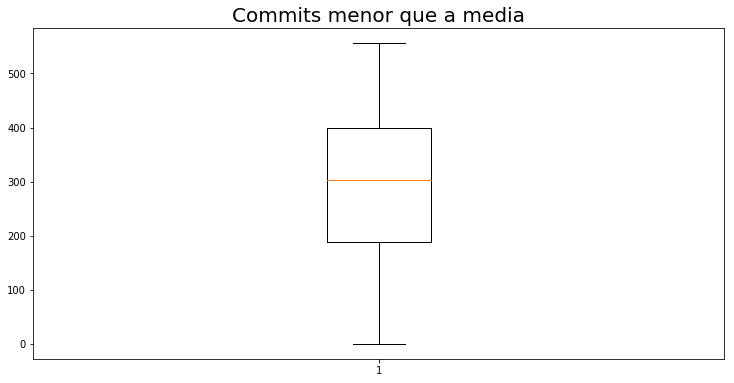

In [40]:
frequency = commit_frequency(commit_project[0], project_name[0])

low, medium, high, veryHigh = all_frequency(frequency, project_name[0])

df = pd.DataFrame(frequency)   
df = df.describe()
print(df)

#plot("Commits menor que a media", frequency)

<font size = 4/>
* Commits menor que a média, projeto RUBY

                0
count  443.000000
mean   237.939052
std    101.329994
min      0.000000
25%    169.500000
50%    231.000000
75%    309.000000
max    419.000000


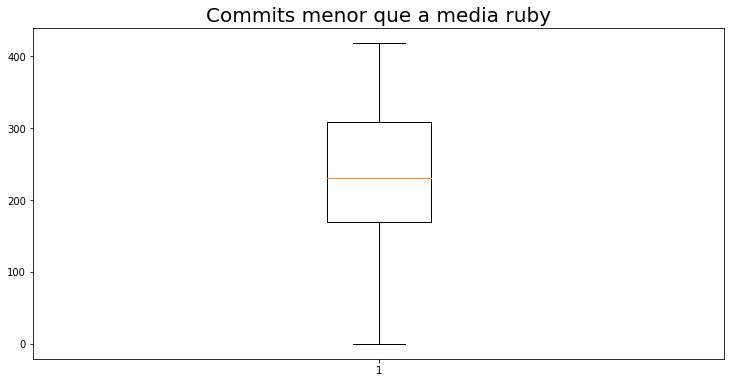

In [41]:
frequency = commit_frequency(commit_project[1], project_name[1])

low, medium, high, veryHigh = all_frequency(frequency, project_name[1])

df = pd.DataFrame(frequency)
df = df.describe()
print(df)

#plot("Commits menor que a media ruby", frequency)


<font size = 4/>
* Frequências de commit por Mês, por tamanho do projeto, pequeno, médio e grande.

<font size = 4/>
* Projetos RUBY 

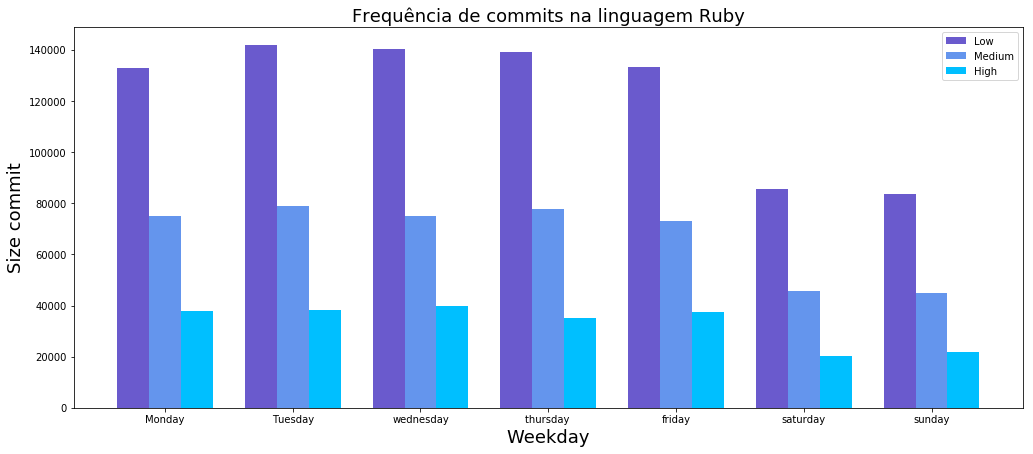

In [103]:
dataframe_l = size_project('ruby', 2)
dataframe_m = size_project('ruby', 3)
dataframe_h = size_project('ruby', 4)

weekday_low = weekday_frequency(dataframe_l)
weekday_medium = weekday_frequency(dataframe_m)
weekday_high = weekday_frequency(dataframe_h)

plot_bar('Ruby', weekday_low, weekday_medium, weekday_high, 1)

<font size = 4/>
* Projetos Java 

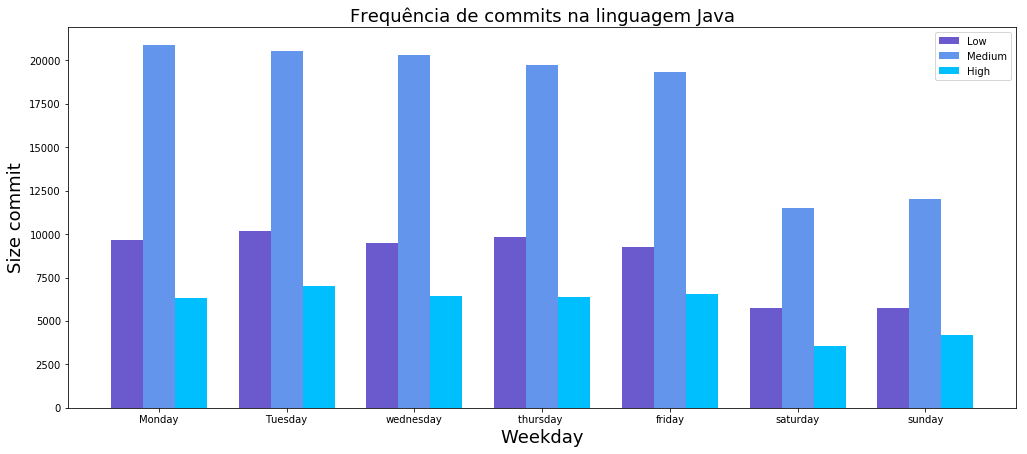

In [105]:
dataframe_l = size_project('java', 2)
dataframe_m = size_project('java', 3)
dataframe_h = size_project('java', 4)

weekday_low = weekday_frequency(dataframe_l)
weekday_medium = weekday_frequency(dataframe_m)
weekday_high = weekday_frequency(dataframe_h)

plot_bar('Java', weekday_low, weekday_medium, weekday_high, 1)

<font size = 4/>
* Frequências de commit por Mês, por tamanho do projeto, pequeno, médio e grande.


<font size = 4/>
* Projetos RUBY 

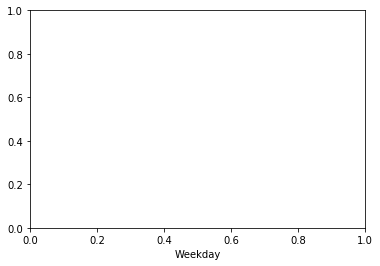

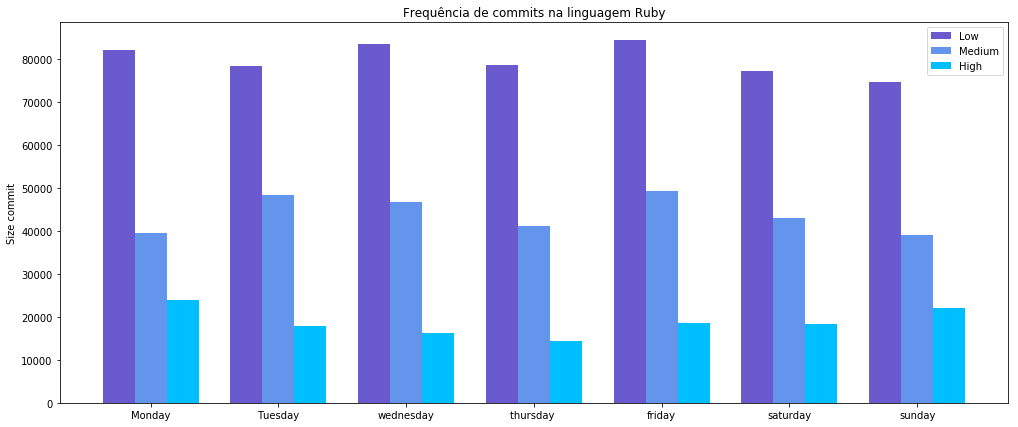

In [80]:
dataframe_l = size_project('ruby', 2)
dataframe_m = size_project('ruby', 3)
dataframe_h = size_project('ruby', 4)

month_low = month_frequency(dataframe_l)
month_medium = month_frequency(dataframe_m)
month_high = month_frequency(dataframe_h)

plot_bar('Ruby', month_low, month_medium, month_high)

<font size = 4/>
* Projetos Java 

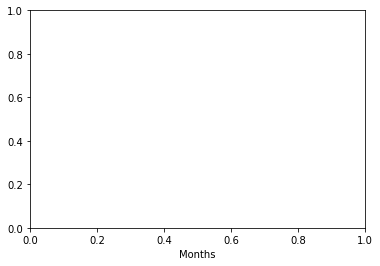

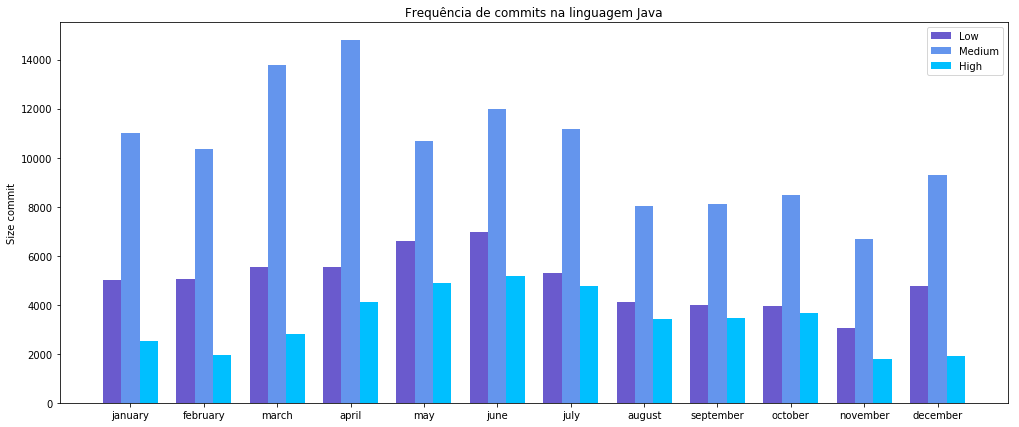

In [81]:
dataframe_l = size_project('java', 2)
dataframe_m = size_project('java', 3)
dataframe_h = size_project('java', 4)

month_low = month_frequency(dataframe_l)
month_medium = month_frequency(dataframe_m)
month_high = month_frequency(dataframe_h)

plot_bar('Java', month_low, month_medium, month_high, 1)